
# 🧰 Tutorial 03 — Preprocessing for Machine Learning

In this notebook, we convert ERA5 data into **ML‑ready arrays**.  
We'll: create **lag features**, reshape to `[samples, features]`, split **by time**, standardize, and save arrays.

> **Tip:** Keep your dataset small while learning. Later, you can scale to larger files or multiple variables.


## 0. Imports & configuration

In [2]:

import os
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Optional: torch export (if installed)
try:
    import torch
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

DATA_PATH = Path("../data/era5_sample.nc")     # adjust if needed
OUT_DIR = Path("../03_preprocessing_for_ml/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TARGET_VAR = "t2m"   # variable to predict
LAGS = [1, 2, 3]     # number of previous timesteps used as features
TEST_FRAC = 0.15
VAL_FRAC = 0.15      # train fraction = 1 - TEST_FRAC - VAL_FRAC


## 1. Load dataset

In [3]:

ds = xr.open_dataset(DATA_PATH)
assert TARGET_VAR in ds.data_vars, f"{TARGET_VAR} not found in dataset. Available: {list(ds.data_vars)}"
var = ds[TARGET_VAR]
var


<xarray.DataArray 't2m' (valid_time: 2, latitude: 721, longitude: 1440)> Size: 8MB
[2076480 values with dtype=float32]
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 16B 2015-09-11T06:00:00 2015-09-1...
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 32B ...
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

## 2. Inspect time dimension and quick preview

Timesteps: 2
First: 2015-09-11T06:00:00.000000000
Last : 2015-09-11T12:00:00.000000000


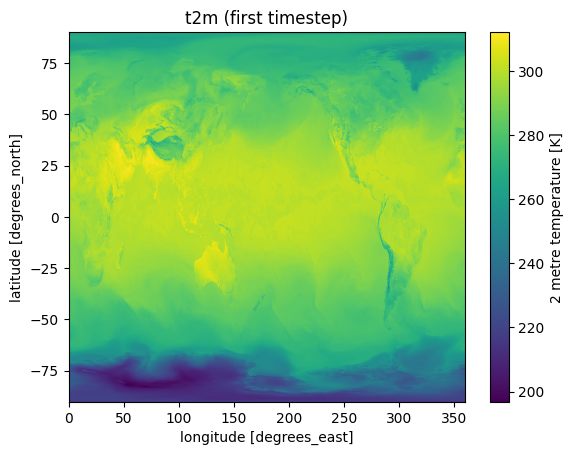

In [6]:

times = var.valid_time.values
print("Timesteps:", len(times))
print("First:", times[0] if len(times) else "N/A")
print("Last :", times[-1] if len(times) else "N/A")

# Quick map of first timestep
_ = var.isel(valid_time=0).plot()
plt.title(f"{TARGET_VAR} (first timestep)")
plt.show()


## 3. Build lag features for supervised learning

In [7]:

# We'll create samples at times t where we have all lags (t-1, t-2, ...)
max_lag = max(LAGS) if LAGS else 0
if var.sizes.get("time", 0) <= max_lag:
    raise ValueError("Not enough timesteps to create lag features. Increase data length or reduce LAGS.")

# Align all lagged arrays by time
lagged = []
for k in LAGS:
    lagged.append(var.shift(time=k).isel(time=slice(max_lag, None)))
target = var.isel(time=slice(max_lag, None))

# Stack space into a single dimension for ML
def stack_space(da):
    # Handle common ERA5 dims: time, latitude, longitude
    spatial_dims = [d for d in da.dims if d not in ("time",)]
    # Ensure consistent order
    da_stacked = da.stack(space=spatial_dims)
    return da_stacked

lagged_stacked = [stack_space(da) for da in lagged]
target_stacked = stack_space(target)

# Drop any rows with NaNs across lags/target
# Concatenate features along the feature axis (lags)
X_list = [da.rename(f"lag_{k}") for da, k in zip(lagged_stacked, LAGS)]
X = xr.concat(X_list, dim="feature")  # dims: time, space, feature
y = target_stacked  # dims: time, space

# Move to numpy with samples axis first: [samples, features]
# We'll collapse (time, space) -> samples
X_np = X.transpose("time", "space", "feature").values.reshape(-1, len(LAGS))
y_np = y.transpose("time", "space").values.reshape(-1)

# Remove any rows where either X or y has NaNs
mask = np.isfinite(X_np).all(axis=1) & np.isfinite(y_np)
X_np = X_np[mask]
y_np = y_np[mask]

print("X shape (samples, features):", X_np.shape)
print("y shape (samples,):", y_np.shape)


ValueError: Not enough timesteps to create lag features. Increase data length or reduce LAGS.

## 4. Time-based train/val/test split

In [ ]:

# For a true time-based split, we need indices per time step, not shuffled samples.
# We'll recompute using per-time slicing then flatten space.

def to_samples_by_time(var, lags):
    max_lag = max(lags) if lags else 0
    # Build per-time feature arrays
    feats = []
    for k in lags:
        feats.append(var.shift(time=k))
    # Valid time range
    valid = slice(max_lag, None)
    feats = [f.isel(time=valid) for f in feats]
    tgt   = var.isel(time=valid)

    def stack_space(da):
        spatial_dims = [d for d in da.dims if d != "time"]
        return da.stack(space=spatial_dims)

    feats = [stack_space(f) for f in feats]
    tgt   = stack_space(tgt)

    # Convert to numpy: time, space -> flatten space but keep time
    F = np.stack([f.values for f in feats], axis=-1)  # shape: time, space, num_lags
    T = tgt.values                                   # shape: time, space

    return F, T  # keep time dimension

F, T = to_samples_by_time(var, LAGS)
time_len, space_len, num_feats = F.shape
print("Per-time shapes:", F.shape, T.shape)

# Split indices by time
n_test = int(np.floor(TEST_FRAC * time_len))
n_val  = int(np.floor(VAL_FRAC  * time_len))
n_train = time_len - n_val - n_test

idx_train = slice(0, n_train)
idx_val   = slice(n_train, n_train + n_val)
idx_test  = slice(n_train + n_val, time_len)

def flatten_time_slice(F, T, slc):
    Fx = F[slc].reshape(-1, F.shape[-1])
    Ty = T[slc].reshape(-1)
    mask = np.isfinite(Fx).all(axis=1) & np.isfinite(Ty)
    return Fx[mask], Ty[mask]

X_train, y_train = flatten_time_slice(F, T, idx_train)
X_val,   y_val   = flatten_time_slice(F, T, idx_val)
X_test,  y_test  = flatten_time_slice(F, T, idx_test)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)
print("Test :", X_test.shape, y_test.shape)


## 5. Standardize features (fit on train, apply to val/test)

In [ ]:

mu = X_train.mean(axis=0, keepdims=True)
sigma = X_train.std(axis=0, keepdims=True)
sigma[sigma == 0] = 1.0  # avoid div by zero

def standardize(X, mu, sigma):
    return (X - mu) / sigma

X_train_std = standardize(X_train, mu, sigma)
X_val_std   = standardize(X_val,   mu, sigma)
X_test_std  = standardize(X_test,  mu, sigma)

print("Means (per feature):", mu.ravel())
print("Stds  (per feature):", sigma.ravel())


## 6. Save arrays to `data/processed/`

In [ ]:

np.save(OUT_DIR / "X_train.npy", X_train_std)
np.save(OUT_DIR / "y_train.npy", y_train)
np.save(OUT_DIR / "X_val.npy",   X_val_std)
np.save(OUT_DIR / "y_val.npy",   y_val)
np.save(OUT_DIR / "X_test.npy",  X_test_std)
np.save(OUT_DIR / "y_test.npy",  y_test)

np.savez(OUT_DIR / "stats.npz", mu=mu, sigma=sigma, lags=np.array(LAGS))

print("Saved:")
for p in sorted(OUT_DIR.glob("*")):
    print(" -", p)


## 7. (Optional) Export as PyTorch tensors

In [ ]:

if TORCH_AVAILABLE:
    torch.save(torch.tensor(X_train_std, dtype=torch.float32), OUT_DIR / "X_train.pt")
    torch.save(torch.tensor(y_train,     dtype=torch.float32), OUT_DIR / "y_train.pt")
    torch.save(torch.tensor(X_val_std,   dtype=torch.float32), OUT_DIR / "X_val.pt")
    torch.save(torch.tensor(y_val,       dtype=torch.float32), OUT_DIR / "y_val.pt")
    torch.save(torch.tensor(X_test_std,  dtype=torch.float32), OUT_DIR / "X_test.pt")
    torch.save(torch.tensor(y_test,      dtype=torch.float32), OUT_DIR / "y_test.pt")
    print("Saved PyTorch tensors.")
else:
    print("PyTorch not installed — skipping tensor export.")



---

## ✅ You now have ML‑ready data!
- Feature matrix with **lagged inputs**
- Target vector aligned in time
- Proper **time-based** train/val/test split
- Standardized features and saved arrays

**Next:** Tutorial 04 — Build a basic ML model (PyTorch) using these arrays.
